Name: Muhammad Haadhee Sheeraz Mian 


Reg no: 478359 


BSCS 13-C 

In [36]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

## Load and inspect data
Australian weather dataset (includes `RainTomorrow` as binary target).

In [37]:
# Speed config (set to None to use full dataset)
SAMPLE_N = 20000

In [38]:
# Load dataset from local file
# Australian weather dataset with RainTomorrow target
df_raw = pd.read_csv("weatherAUS.csv")
df_raw.head(), df_raw.shape

(         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
 0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
 1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
 2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
 3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
 4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   
 
   WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
 0           W           44.0          W        WNW          20.0   
 1         WNW           44.0        NNW        WSW           4.0   
 2         WSW           46.0          W        WSW          19.0   
 3          NE           24.0         SE          E          11.0   
 4           W           41.0        ENE         NW           7.0   
 
    WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  \
 0          24.0         71.0   

In [39]:
# Quick info on types and missingness
missing_summary = df_raw.isna().mean().sort_values(ascending=False)
display(df_raw.dtypes.head(10))
missing_summary.head(10)

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
dtype: object

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
dtype: float64

## Helper functions: feature engineering, preprocessing, evaluation
We add interpretable engineered features, build reusable preprocessing, and define evaluation with focus on recall for rain (`Yes`).

In [40]:
def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Temperature dynamics
    df['TempRange'] = df['MaxTemp'] - df['MinTemp']
    df['TempSpread9to3'] = df['Temp3pm'] - df['Temp9am']
    # Humidity and pressure differences
    df['HumidityDiff'] = df['Humidity3pm'] - df['Humidity9am']
    df['PressureDiff'] = df['Pressure3pm'] - df['Pressure9am']
    # Wind related interactions
    df['WindSpeedRatio'] = df['WindSpeed3pm'] / (df['WindSpeed9am'] + 1e-3)
    # Rainfall stabilization (log1p handles zeros)
    df['RainfallLog'] = np.log1p(df['Rainfall'])
    # Binning for interpretability
    df['TempBin'] = pd.cut(df['Temp3pm'], bins=[-20, 10, 20, 35, 60], labels=['cold', 'mild', 'warm', 'hot'])
    return df

def build_preprocessor(df: pd.DataFrame):
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    numeric_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('num', numeric_pipe, numeric_cols),
        ('cat', categorical_pipe, categorical_cols)
    ])
    return preprocessor, numeric_cols, categorical_cols

def evaluate_model(model, X_train, X_test, y_train, y_test, labels=('No','Yes')):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    print(classification_report(y_test, preds, target_names=labels))
    cm = confusion_matrix(y_test, preds, labels=[0,1])
    ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap='Blues')
    plt.show()
    if probs is not None:
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
        return {'precision': precision, 'recall': recall, 'f1': f1}
    return None

## Prepare data and baseline models
- Add engineered features.
- Split into train/test.
- Baseline Logistic Regression (balanced class weights) and Random Forest.

Logistic Regression baseline
              precision    recall  f1-score   support

          No       0.93      0.82      0.87     22064
         Yes       0.55      0.79      0.65      6375

    accuracy                           0.81     28439
   macro avg       0.74      0.80      0.76     28439
weighted avg       0.85      0.81      0.82     28439



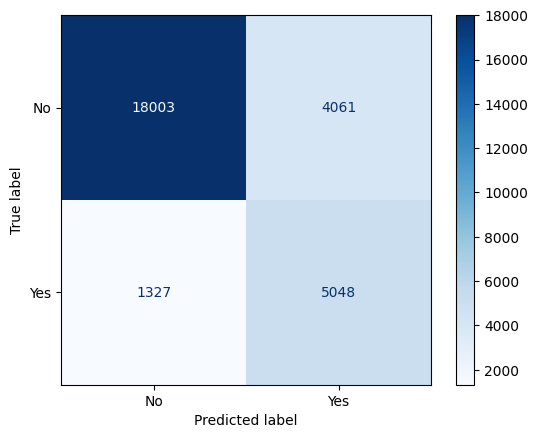


Random Forest baseline
              precision    recall  f1-score   support

          No       0.86      0.97      0.91     22064
         Yes       0.80      0.47      0.59      6375

    accuracy                           0.85     28439
   macro avg       0.83      0.72      0.75     28439
weighted avg       0.85      0.85      0.84     28439



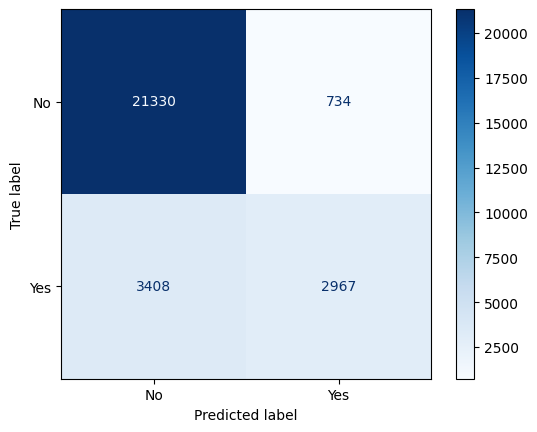

In [41]:
df = add_engineered_features(df_raw)
# Target encode: Yes -> 1, No -> 0
df['RainTomorrowFlag'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})
df.drop(columns=['RainTomorrow'], inplace=True)

# Drop rows with missing target values
df = df.dropna(subset=['RainTomorrowFlag'])

X = df.drop(columns=['RainTomorrowFlag'])
y = df['RainTomorrowFlag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

preprocessor, num_cols, cat_cols = build_preprocessor(X)

log_reg = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
])

print('Logistic Regression baseline')
eval_log = evaluate_model(log_reg, X_train, X_test, y_train, y_test)
print('\nRandom Forest baseline')
eval_rf = evaluate_model(rf, X_train, X_test, y_train, y_test)

## Filter method: Mutual Information (SelectKBest)
Keeps top-k signals after preprocessing.

Mutual information selection (k=25)
              precision    recall  f1-score   support

          No       0.92      0.80      0.86     22064
         Yes       0.53      0.77      0.63      6375

    accuracy                           0.79     28439
   macro avg       0.73      0.79      0.74     28439
weighted avg       0.84      0.79      0.81     28439



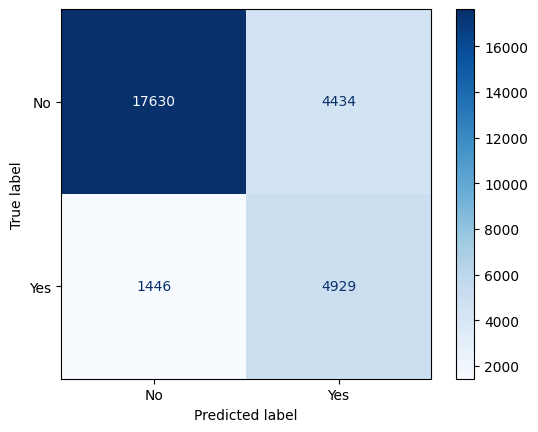

In [42]:
k_best = 25
mi_selector = SelectKBest(mutual_info_classif, k=k_best)
log_reg_mi = Pipeline([
    ('pre', preprocessor),
    ('mi', mi_selector),

       
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
print(f'Mutual information selection (k={k_best})')
eval_mi = evaluate_model(log_reg_mi, X_train, X_test, y_train, y_test)

## Wrapper method: Recursive Feature Elimination (RFE) with Logistic Regression
Ranks features iteratively; keeps top 30.

RFE selection (top 30 features)
              precision    recall  f1-score   support

          No       0.78      1.00      0.87     22064
         Yes       0.43      0.01      0.02      6375

    accuracy                           0.77     28439
   macro avg       0.60      0.50      0.45     28439
weighted avg       0.70      0.77      0.68     28439



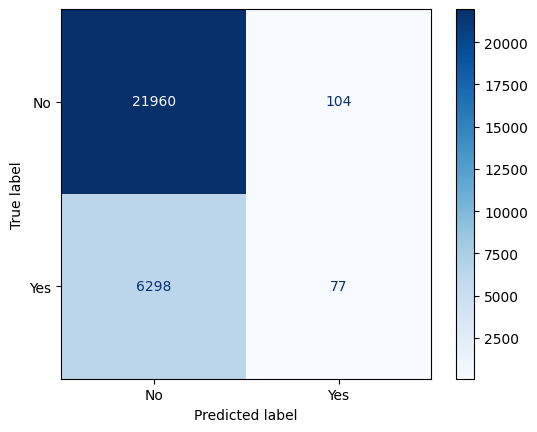

In [43]:
rfe_estimator = LogisticRegression(max_iter=1000, class_weight='balanced')
rfe = RFE(estimator=rfe_estimator, n_features_to_select=30, step=0.1)
log_reg_rfe = Pipeline([
    ('pre', preprocessor),
    ('rfe', rfe),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
print('RFE selection (top 30 features)')
eval_rfe = evaluate_model(log_reg_rfe, X_train, X_test, y_train, y_test)

## Embedded method: L1-penalized Logistic Regression (sparse coefficients)
Uses L1 to zero-out weak features.

L1 logistic regression (embedded)
              precision    recall  f1-score   support

          No       0.93      0.81      0.87     22064
         Yes       0.55      0.79      0.65      6375

    accuracy                           0.81     28439
   macro avg       0.74      0.80      0.76     28439
weighted avg       0.85      0.81      0.82     28439



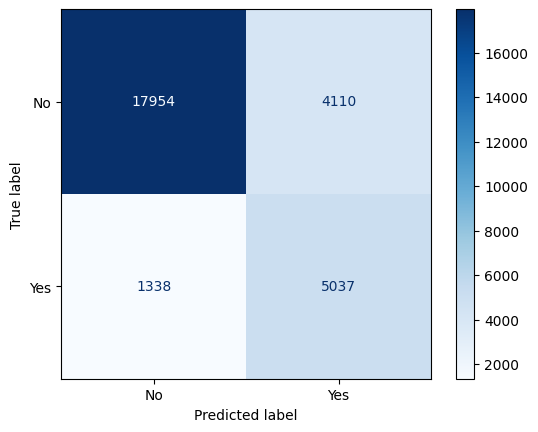

In [44]:
log_reg_l1 = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(penalty='l1', solver='saga', max_iter=2000, class_weight='balanced', C=0.5))
])
print('L1 logistic regression (embedded)')
eval_l1 = evaluate_model(log_reg_l1, X_train, X_test, y_train, y_test)

## Tree-based importance and permutation importance
Random Forest provides impurity-based importance; permutation importance adds model-agnostic perspective.

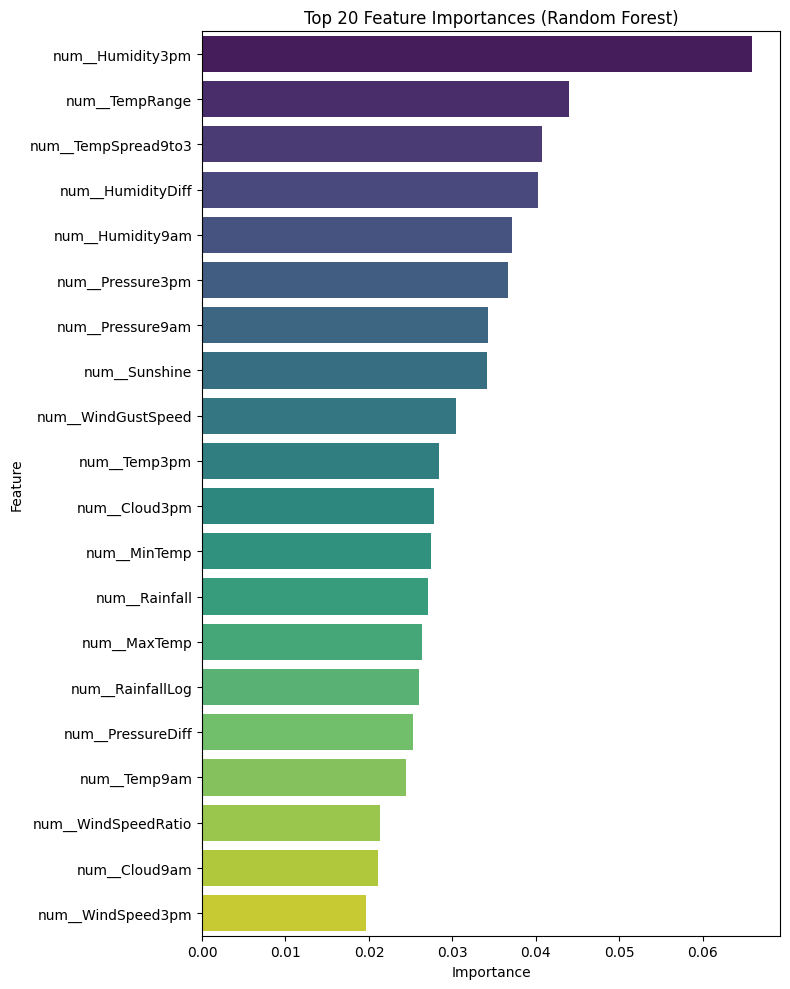

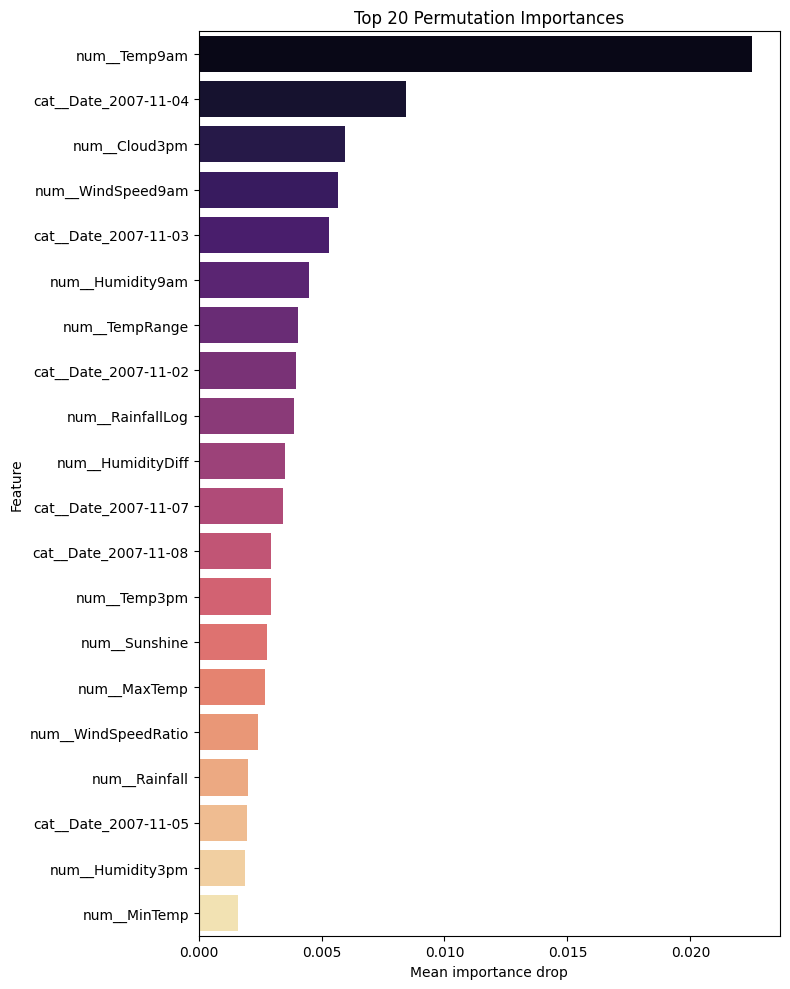

In [45]:
# Fit RF once to extract importances and transformed feature names
rf_clf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
rf_pipe = Pipeline([('pre', preprocessor), ('clf', rf_clf)])
rf_pipe.fit(X_train, y_train)

feature_names = rf_pipe.named_steps['pre'].get_feature_names_out()
importances = rf_pipe.named_steps['clf'].feature_importances_
sorted_idx = np.argsort(importances)[::-1][:20]
plt.figure(figsize=(8, 10))
sns.barplot(x=importances[sorted_idx], y=feature_names[sorted_idx], palette='viridis')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

perm = permutation_importance(rf_pipe, X_test, y_test, n_repeats=10, random_state=42)
perm_idx = np.argsort(perm.importances_mean)[::-1][:20]
plt.figure(figsize=(8, 10))
sns.barplot(x=perm.importances_mean[perm_idx], y=feature_names[perm_idx], palette='magma')
plt.title('Top 20 Permutation Importances')
plt.xlabel('Mean importance drop')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Correlation heatmap (numeric only)
Helps spot redundant predictors before modeling.

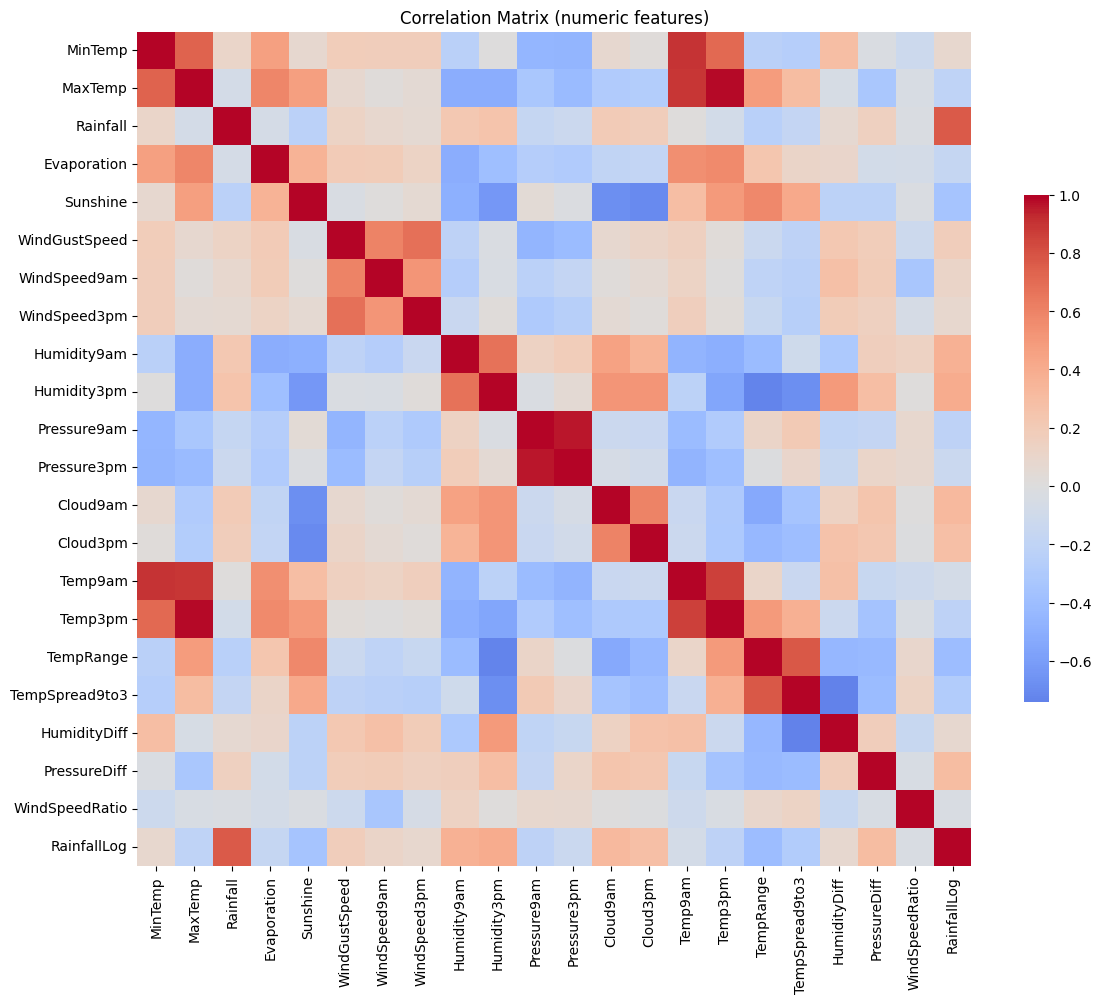

In [46]:
numeric_df = df.select_dtypes(include=['number']).drop(columns=['RainTomorrowFlag'])
plt.figure(figsize=(12, 10))
corr = numeric_df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': 0.6})
plt.title('Correlation Matrix (numeric features)')
plt.tight_layout()
plt.show()

## Results snapshot
Compare key metrics side by side.

In [47]:
results = pd.DataFrame([
    {'model': 'LogReg baseline', **(eval_log or {})},
    {'model': 'RandomForest baseline', **(eval_rf or {})},
    {'model': 'MI + LogReg', **(eval_mi or {})},
    {'model': 'RFE + LogReg', **(eval_rfe or {})},
    {'model': 'L1 LogReg', **(eval_l1 or {})}
])
results

,model,precision,recall,f1
0,LogReg baseline,0.554177,0.791843,0.652028
1,RandomForest baseline,0.801675,0.465412,0.588924
2,MI + LogReg,0.526434,0.773176,0.626382
3,RFE + LogReg,0.425414,0.012078,0.023490
4,L1 LogReg,0.550672,0.790118,0.649014
